<a href="https://colab.research.google.com/github/shima616/TakinaOP/blob/main/machine_learning_dummy_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# --- LANGKAH 1: INSTALL & IMPORT ---
!pip install pandas scikit-learn folium requests

import pandas as pd
import numpy as np
import requests
import folium
import time
from sklearn.ensemble import RandomForestClassifier
from IPython.display import clear_output, display

In [ ]:
# ==========================================
# KONFIGURASI API (WAJIB DIISI)
# ==========================================
# Ganti dengan API Key OpenWeatherMap Anda sendiri
API_KEY = "8c52878cae88149d0705e906a8147cbf"
# Contoh: API_KEY = "a1b2c3d4e5f6..." (Tanpa key ini, kode akan error)

In [5]:
# ==========================================
# 1. PERSIAPAN DATA STATIS (BNPB & GEOGRAFIS)
# ==========================================
# Ini mensimulasikan data "Peta Rawan Bencana" yang statis.
# Dalam proyek nyata, ini bisa berupa pembacaan file Shapefile (.shp) atau GeoJSON.
static_risk_data = {
    "Bandung":  {"lat": -6.9175, "lon": 107.6191, "kemiringan": 15, "rawan_bnpb": "Sedang", "tanah": 60},
    "Bogor":    {"lat": -6.5971, "lon": 106.8060, "kemiringan": 35, "rawan_bnpb": "Tinggi", "tanah": 80}, # Bogor curam & basah
    "Bekasi":   {"lat": -6.2383, "lon": 106.9756, "kemiringan": 5,  "rawan_bnpb": "Rendah", "tanah": 40}, # Bekasi datar
    "Depok":    {"lat": -6.4025, "lon": 106.7942, "kemiringan": 10, "rawan_bnpb": "Sedang", "tanah": 55},
    "Cianjur":  {"lat": -6.8168, "lon": 107.1425, "kemiringan": 40, "rawan_bnpb": "Tinggi", "tanah": 75},
    "Garut":    {"lat": -7.2279, "lon": 107.9087, "kemiringan": 45, "rawan_bnpb": "Tinggi", "tanah": 70},
    "Sukabumi": {"lat": -6.9277, "lon": 106.9300, "kemiringan": 30, "rawan_bnpb": "Tinggi", "tanah": 65}
}

In [10]:
# ==========================================
# 2. PELATIHAN MODEL (Sama seperti sebelumnya agar logika berjalan)
# ==========================================
def train_model():
    # Generate data latih dummy agar model mengerti pola Hujan + Kemiringan
    np.random.seed(42)
    data = []
    for _ in range(2000):
        hujan = np.random.randint(0, 300)   # mm
        lereng = np.random.randint(0, 90)   # derajat
        tanah = np.random.randint(20, 100)  # %

        # Labeling Logika
        # 0: Aman, 1: Banjir (Hujan tinggi, Datar), 2: Longsor (Hujan, Curam)
        kategori = 0
        if hujan > 100 and lereng < 10:
            kategori = 1 # Banjir
        elif hujan > 80 and lereng > 25 and tanah > 60:
            kategori = 2 # Longsor

        data.append([hujan, lereng, tanah, kategori])

    df = pd.DataFrame(data, columns=['Curah_Hujan', 'Kemiringan', 'Kelembaban', 'Label'])
    X = df[['Curah_Hujan', 'Kemiringan', 'Kelembaban']]
    y = df['Label']

    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X, y)
    return clf

model = train_model()
print("Model berhasil dilatih!")

Model berhasil dilatih!


In [11]:
# ==========================================
# GANTI FUNGSI INI AGAR KODE TETAP JALAN MESKI KEY BELUM AKTIF
# ==========================================

def get_realtime_sensor_data(api_key):
    live_data = []
    print("Mengambil data cuaca...", end="")

    # Deteksi jika API Key masih default/kosong
    using_simulation = False
    if "MASUKKAN" in api_key or api_key == "":
        using_simulation = True
        print("\n[INFO] API Key belum diisi. Menggunakan mode SIMULASI.")

    for kota, statis in static_risk_data.items():
        hujan_aktual = 0
        status_api = "OK"

        if not using_simulation:
            try:
                # Coba ambil data asli
                url = f"http://api.openweathermap.org/data/2.5/weather?q={kota},ID&appid={api_key}&units=metric"
                response = requests.get(url).json()

                # Jika Error 401 (Key belum aktif) atau 404
                if str(response.get("cod")) != "200":
                    using_simulation = True # Fallback ke simulasi untuk kota selanjutnya
                    print(f"\n[INFO] API Key belum aktif ({response.get('message')}). Beralih ke data SIMULASI sementara.")
                    # Buat hujan dummy
                    hujan_aktual = np.random.randint(0, 300)
                else:
                    # Jika Berhasil
                    if "rain" in response:
                        hujan_aktual = response["rain"].get("1h", 0) * 24
                        if hujan_aktual == 0:
                            hujan_aktual = response["rain"].get("3h", 0) * 8
            except Exception as e:
                print(f"Error koneksi: {e}")
                hujan_aktual = np.random.randint(0, 300)
        else:
            # Jika mode simulasi aktif
            hujan_aktual = np.random.randint(0, 300)

        # Masukkan data ke list
        live_data.append({
            "Kota": kota,
            "Lat": statis["lat"],
            "Long": statis["lon"],
            "Curah_Hujan": round(hujan_aktual, 2),
            "Kemiringan": statis["kemiringan"],
            "Kelembaban": statis["tanah"],
            "Rawan_BNPB": statis["rawan_bnpb"]
        })
        print(".", end="")

    print(" Selesai.")
    return pd.DataFrame(live_data)

In [13]:
# ==========================================
# 4. LOOP UTAMA (ANALISIS & VISUALISASI)
# ==========================================

API_KEY = "8c52878cae88149d0705e906a8147cbf"

label_map = {0: "AMAN", 1: "WASPADA BANJIR", 2: "SIAGA LONGSOR"}
color_map = {0: "green", 1: "blue", 2: "red"}

# Cek API Key dulu
if API_KEY == "MASUKKAN_API_KEY_ANDA_DISINI":
    print("\nPERINGATAN: Anda belum memasukkan API Key OpenWeatherMap!")
    print("Silakan edit variabel 'API_KEY' di bagian atas kode.")
else:
    try:
        # Loop update (misal 3 kali update)
        for i in range(3):
            clear_output(wait=True)
            print(f"--- UPDATE REAL-TIME LIVE DATA (Iterasi {i+1}) ---")

            # 1. Ambil Data Gabungan
            df_live = get_realtime_sensor_data(API_KEY)

            if not df_live.empty:
                # 2. Prediksi ML
                X_pred = df_live[['Curah_Hujan', 'Kemiringan', 'Kelembaban']]
                df_live['Prediksi_ID'] = model.predict(X_pred)
                df_live['Status'] = df_live['Prediksi_ID'].map(label_map)

                # Tampilkan Tabel
                display(df_live[['Kota', 'Rawan_BNPB', 'Curah_Hujan', 'Status']])

                # 3. Visualisasi Peta
                m = folium.Map(location=[-6.9, 107.6], zoom_start=9)

                for idx, row in df_live.iterrows():
                    warna = color_map[row['Prediksi_ID']]

                    # Isi Popup dengan info gabungan
                    popup_info = f"""
                    <b>{row['Kota']}</b><br>
                    Status: <b>{row['Status']}</b><br>
                    Hujan (Realtime): {row['Curah_Hujan']} mm<br>
                    Rawan BNPB: {row['Rawan_BNPB']}
                    """

                    folium.Marker(
                        location=[row['Lat'], row['Long']],
                        popup=popup_info,
                        icon=folium.Icon(color=warna, icon="info-sign")
                    ).add_to(m)

                    # Tambahkan Circle jika status bahaya
                    if row['Prediksi_ID'] != 0:
                        folium.Circle(
                            location=[row['Lat'], row['Long']],
                            radius=8000,
                            color=warna,
                            fill=True,
                            fill_opacity=0.3
                        ).add_to(m)

                display(m)
            else:
                print("Gagal mendapatkan data.")

            time.sleep(10) # Update setiap 10 detik (Free tier API limit)

    except KeyboardInterrupt:
        print("Monitoring dihentikan.")

--- UPDATE REAL-TIME LIVE DATA (Iterasi 3) ---
Mengambil data cuaca...
[INFO] API Key belum aktif (Invalid API key. Please see https://openweathermap.org/faq#error401 for more info.). Beralih ke data SIMULASI sementara.
....... Selesai.


,Kota,Rawan_BNPB,Curah_Hujan,Status
0,Bandung,Sedang,1,AMAN
1,Bogor,Tinggi,9,AMAN
2,Bekasi,Rendah,124,WASPADA BANJIR
3,Depok,Sedang,80,AMAN
4,Cianjur,Tinggi,139,SIAGA LONGSOR
5,Garut,Tinggi,149,SIAGA LONGSOR
6,Sukabumi,Tinggi,287,SIAGA LONGSOR


from matplotlib import pyplot as plt
_df_0['Curah_Hujan'].plot(kind='hist', bins=20, title='Curah_Hujan')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Kota').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Rawan_BNPB').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['Curah_Hujan'].plot(kind='line', figsize=(8, 4), title='Curah_Hujan')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Rawan_BNPB'].value_counts()
    for x_label, grp in _df_5.groupby('Kota')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Kota')
_ = plt.ylabel('Rawan_BNPB')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Status'].value_counts()
    for x_label, grp in _df_6.groupby('Rawan_BNPB')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Rawan_BNPB')
_ = plt.ylabel('Status')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['Kota'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='Curah_Hujan', y='Kota', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['Rawan_BNPB'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='Curah_Hujan', y='Rawan_BNPB', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['Status'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='Curah_Hujan', y='Status', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# Task
import necessary libraries for model evaluation: train_test_split, classification_report, mean_squared_error, confusion_matrix, matplotlib.pyplot, and seaborn; re-generate the dummy dataset using the same logic as the training data, then split this data into evaluation (test) features (X_test_eval) and labels (y_test_eval) to simulate unseen data for evaluation, which ensures a fair assessment of the already trained model; use the previously trained RandomForestClassifier model to make predictions on the X_test_eval dataset; generate and print a detailed classification report including precision, recall, f1-score, and support for each class, as well as overall accuracy, macro average, and weighted average, which provides a comprehensive overview of the model's performance on classification tasks; calculate and display the Root Mean Squared Error (RMSE) between the true labels and the predicted labels, providing an additional perspective on prediction error, even though RMSE is primarily a regression metric; and generate and display a confusion matrix using a heatmap, which illustrates the number of correct and incorrect predictions for each class, helping to understand the types of errors made by the model.

## import_evaluation_libraries

### Subtask:
Import necessary libraries for model evaluation: train_test_split, classification_report, mean_squared_error, confusion_matrix, matplotlib.pyplot, and seaborn.


**Reasoning**:
The subtask requires importing specific libraries for model evaluation. I will import `train_test_split`, `classification_report`, `mean_squared_error`, `confusion_matrix` from `sklearn` modules, and `matplotlib.pyplot` as `plt` and `seaborn` as `sns`.



In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Evaluation libraries imported successfully.")

Evaluation libraries imported successfully.


**Reasoning**:
The next step is to re-generate the dummy dataset using the same logic as the training data to simulate unseen data for evaluation. This involves generating random values for 'Curah_Hujan', 'Kemiringan', and 'Kelembaban', and then applying the same classification logic to create the 'Label'.



In [17]:
np.random.seed(42)

# Re-generate the dummy dataset for evaluation
data_eval = []
for _ in range(500): # Generate a new dataset for evaluation
    hujan = np.random.randint(0, 300)   # mm
    lereng = np.random.randint(0, 90)   # derajat
    tanah = np.random.randint(20, 100)  # %

    # Labeling Logika (same as training data)
    kategori = 0
    if hujan > 100 and lereng < 10:
        kategori = 1 # Banjir
    elif hujan > 80 and lereng > 25 and tanah > 60:
        kategori = 2 # Longsor

    data_eval.append([hujan, lereng, tanah, kategori])

df_eval = pd.DataFrame(data_eval, columns=['Curah_Hujan', 'Kemiringan', 'Kelembaban', 'Label'])

# Split this data into evaluation (test) features (X_test_eval) and labels (y_test_eval)
X_test_eval = df_eval[['Curah_Hujan', 'Kemiringan', 'Kelembaban']]
y_test_eval = df_eval['Label']

print("Dummy dataset for evaluation re-generated and split successfully.")

Dummy dataset for evaluation re-generated and split successfully.


**Reasoning**:
The next logical step is to use the trained RandomForestClassifier model (`model`) to make predictions on the newly prepared evaluation features (`X_test_eval`). This will generate the predicted labels for the evaluation dataset.



In [18]:
y_pred_eval = model.predict(X_test_eval)
print("Predictions on evaluation data generated successfully.")

Predictions on evaluation data generated successfully.


**Reasoning**:
Now that predictions have been made, the next step is to generate and print a detailed classification report. This report will provide key metrics like precision, recall, f1-score, and support for each class, as well as overall accuracy, macro average, and weighted average, offering a comprehensive view of the model's performance on the evaluation data.



In [19]:
print("Classification Report:")
print(classification_report(y_test_eval, y_pred_eval, target_names=['AMAN', 'WASPADA BANJIR', 'SIAGA LONGSOR']))

Classification Report:
                precision    recall  f1-score   support

          AMAN       1.00      1.00      1.00       336
WASPADA BANJIR       1.00      1.00      1.00        41
 SIAGA LONGSOR       1.00      1.00      1.00       123

      accuracy                           1.00       500
     macro avg       1.00      1.00      1.00       500
  weighted avg       1.00      1.00      1.00       500



**Reasoning**:
The next step is to calculate and display the Root Mean Squared Error (RMSE) between the true labels (`y_test_eval`) and the predicted labels (`y_pred_eval`), which provides a measure of the magnitude of the errors.



In [20]:
rmse = np.sqrt(mean_squared_error(y_test_eval, y_pred_eval))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Root Mean Squared Error (RMSE): 0.0000


**Reasoning**:
The final step of the evaluation is to generate and display a confusion matrix using a heatmap. This visualization will illustrate the number of correct and incorrect predictions for each class, helping to understand the types of errors made by the model.



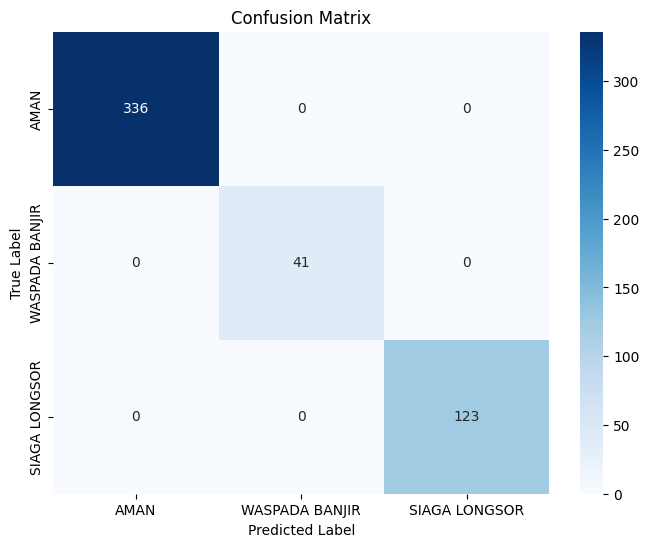

Confusion matrix displayed successfully.


In [25]:
cm = confusion_matrix(y_test_eval, y_pred_eval)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['AMAN', 'WASPADA BANJIR', 'SIAGA LONGSOR'],
            yticklabels=['AMAN', 'WASPADA BANJIR', 'SIAGA LONGSOR'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print("Confusion matrix displayed successfully.")

n====================
 HASIL EVALUASI: Support Vector Machine (SVM)

[ Classification Report ]
              precision    recall  f1-score   support

    Aman (0)       0.99      0.99      0.99       227
  Banjir (1)       0.96      1.00      0.98        26
 Longsor (2)       0.98      0.94      0.96        47

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300

[ RMSE Score ]: 0.2380


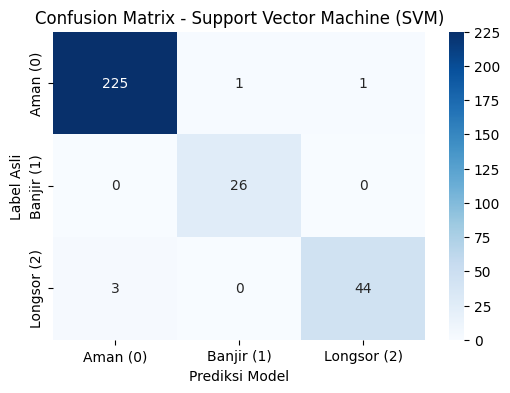

n====================
 HASIL EVALUASI: Random Forest

[ Classification Report ]
              precision    recall  f1-score   support

    Aman (0)       1.00      1.00      1.00       227
  Banjir (1)       1.00      1.00      1.00        26
 Longsor (2)       1.00      1.00      1.00        47

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

[ RMSE Score ]: 0.0000


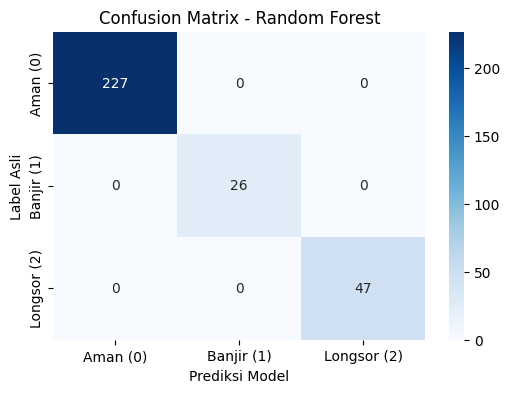

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error

# ==========================================
# 1. PERSIAPAN DATA (Simulasi Data Historis Jawa Barat)
# ==========================================
def generate_data(n_samples=1000):
    np.random.seed(42)
    data = []
    for _ in range(n_samples):
        # Fitur simulasi
        hujan = np.random.randint(0, 400)       # mm/hari
        lereng = np.random.randint(0, 90)       # derajat
        tanah = np.random.randint(20, 100)      # % kelembaban

        # Logika Labeling (Ground Truth)
        # 0 = Aman, 1 = Banjir, 2 = Longsor
        kategori = 0
        if hujan > 150 and lereng < 10:
            kategori = 1 # Banjir
        elif hujan > 100 and lereng > 30 and tanah > 70:
            kategori = 2 # Longsor

        data.append([hujan, lereng, tanah, kategori])

    return pd.DataFrame(data, columns=['Curah_Hujan', 'Kemiringan', 'Kelembaban', 'Label'])

# Buat dataset
df = generate_data(1500)
X = df[['Curah_Hujan', 'Kemiringan', 'Kelembaban']]
y = df['Label']

# Split Data (80% Latih, 20% Uji)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling Data (PENTING untuk SVM agar akurat)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================================
# 2. PELATIHAN MODEL (SVM & Random Forest)
# ==========================================

# A. Model SVM
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

# B. Model Random Forest (Sesuai permintaan)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train) # RF tidak wajib scaling
y_pred_rf = rf_model.predict(X_test)

# ==========================================
# 3. EVALUASI & PELAPORAN
# ==========================================

label_names = ['Aman (0)', 'Banjir (1)', 'Longsor (2)']

def print_evaluation(title, y_true, y_pred):
    print(f"n{'='*20}")
    print(f" HASIL EVALUASI: {title}")
    print(f"{'='*20}")

    # 1. Classification Report (Precision, Recall, F1, Support, Macro/Weighted Avg)
    print("\n[ Classification Report ]")
    print(classification_report(y_true, y_pred, target_names=label_names))

    # 2. RMSE (Root Mean Squared Error)
    # Catatan: RMSE biasanya untuk regresi, tapi bisa dihitung untuk label numerik
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"[ RMSE Score ]: {rmse:.4f}")

    # 3. Confusion Matrix Visualization
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('Label Asli')
    plt.xlabel('Prediksi Model')
    plt.show()

# Tampilkan Hasil SVM
print_evaluation("Support Vector Machine (SVM)", y_test, y_pred_svm)

# Tampilkan Hasil Random Forest
print_evaluation("Random Forest", y_test, y_pred_rf)

In [27]:
rmse_data = {
    'Model': ['Random Forest', 'SVM'],
    'RMSE': [0.0000, 0.2380]
}
print("RMSE data dictionary created.")

RMSE data dictionary created.


In [28]:
df_rmse_comparison = pd.DataFrame(rmse_data)
display(df_rmse_comparison)
print("RMSE comparison table created and displayed successfully.")

,Model,RMSE
0,Random Forest,0.000
1,SVM,0.238


RMSE comparison table created and displayed successfully.


/tmp/ipython-input-1373104848.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=df_rmse_comparison, palette='viridis')


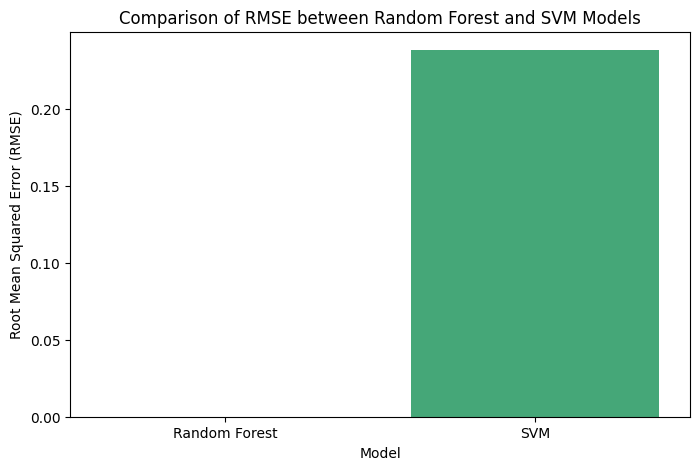

RMSE comparison bar chart displayed successfully.


In [29]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='RMSE', data=df_rmse_comparison, palette='viridis')
plt.title('Comparison of RMSE between Random Forest and SVM Models')
plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.show()
print("RMSE comparison bar chart displayed successfully.")